In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
# from patchify import *
# from preprocessing import *

In [22]:
mr1 = np.load('./data/visceral_full/test/10000136_1_CTce_ThAb.npz')['data']
print(mr1.shape)
print(mr1.mean(), mr1.std()) # almost 0
print(np.max(mr1), np.min(mr1))

(590, 110, 300)
-0.6170891 0.21596439
0.8440753 -1.0


In [ ]:
import time


def reconstruct_scan(scan):
    """
        Only supports coronal scans for now!
    """
    
    rec_scan = []
    _, y, _ = scan.shape
    
    for i in range(y):
        sl = scan[:, i, :]
        original_shape = sl.shape
        
        # patchify - only step=1 works
        patches = patchify(sl, (256, 256), step=1)
        rec_patches = []
        
        for patch in patches:
            # set up data here
            
            # run inference
            rec_patches.append(patch)
        
        rec_patches = np.array(rec_patches).reshape(original_shape)
        rec_scan.append(rec_patches)
    
    rec_scan = np.array(rec_scan)
    return rec_scan

start = time.time()
m1_slice = mr1[:,100,:]
print(m1_slice.shape)

# # patchify
patches = patchify(m1_slice, (256, 256), step=1)
or_shape = patches.shape 
patches = patches.reshape(-1, 256, 256)


# former_shape = patches.shape
# print(patches.shape)
# # save the dimension here

# # print(patches.reshape(-1, 256, 1, 256).shape)
# # print(patches.reshape(former_shape).shape)

# # # unpatchify
rev_patches = unpatchify(patches.reshape(or_shape), m1_slice.shape)
# end = time.time()
# print(end - start)
# print(rev_patches.shape)

# rec_mr1 = reconstruct_scan(mr1[:, 50:51, :])

print(rev_patches.shape)

(1886, 485)


/Users/muhammad/anaconda3/lib/python3.6/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


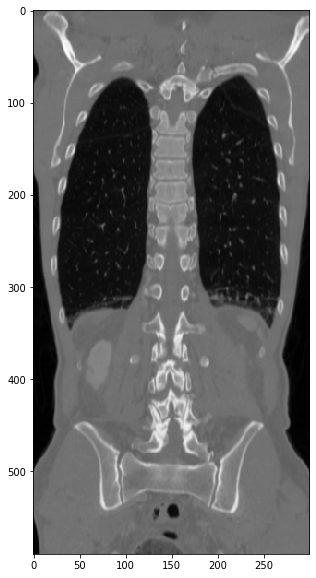

In [24]:
plt.figure(figsize=(10,10))

plt.imshow(np.flip(mr1[:, 60, :]))
plt.show()


In [8]:
import numpy as np
image = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])

patches = patchify(image, (2,2), step=2) # split image into 2*3 small 2*2 patches.

reconstructed_image = unpatchify(patches, image.shape)


ZeroDivisionError: division by zero

##  Another approach... Use torch!

In [2]:
import torch
import numpy as np

def extract_patches_2d(img,patch_shape,step=[1.0,1.0],batch_first=False):
    patch_H, patch_W = patch_shape[0], patch_shape[1]
    if(img.size(2)<patch_H):
        num_padded_H_Top = (patch_H - img.size(2))//2
        num_padded_H_Bottom = patch_H - img.size(2) - num_padded_H_Top
        padding_H = nn.ConstantPad2d((0,0,num_padded_H_Top,num_padded_H_Bottom),0)
        img = padding_H(img)
    if(img.size(3)<patch_W):
        num_padded_W_Left = (patch_W - img.size(3))//2
        num_padded_W_Right = patch_W - img.size(3) - num_padded_W_Left
        padding_W = nn.ConstantPad2d((num_padded_W_Left,num_padded_W_Right,0,0),0)
        img = padding_W(img)
    step_int = [0,0]
    step_int[0] = int(patch_H*step[0]) if(isinstance(step[0], float)) else step[0]
    step_int[1] = int(patch_W*step[1]) if(isinstance(step[1], float)) else step[1]
    patches_fold_H = img.unfold(2, patch_H, step_int[0])
    if((img.size(2) - patch_H) % step_int[0] != 0):
        patches_fold_H = torch.cat((patches_fold_H,img[:,:,-patch_H:,].permute(0,1,3,2).unsqueeze(2)),dim=2)
    patches_fold_HW = patches_fold_H.unfold(3, patch_W, step_int[1])   
    if((img.size(3) - patch_W) % step_int[1] != 0):
        patches_fold_HW = torch.cat((patches_fold_HW,patches_fold_H[:,:,:,-patch_W:,:].permute(0,1,2,4,3).unsqueeze(3)),dim=3)
    patches = patches_fold_HW.permute(2,3,0,1,4,5)
    patches = patches.reshape(-1,img.size(0),img.size(1),patch_H,patch_W)
    if(batch_first):
        patches = patches.permute(1,0,2,3,4)
    return patches

def reconstruct_from_patches_2d(patches,img_shape,step=[1.0,1.0],batch_first=False):
    if(batch_first):
        patches = patches.permute(1,0,2,3,4)
    patch_H, patch_W = patches.size(3), patches.size(4)
    img_size = (patches.size(1), patches.size(2),max(img_shape[0], patch_H), max(img_shape[1], patch_W))
    step_int = [0,0]
    step_int[0] = int(patch_H*step[0]) if(isinstance(step[0], float)) else step[0]
    step_int[1] = int(patch_W*step[1]) if(isinstance(step[1], float)) else step[1]
    nrow, ncol = 1 + (img_size[-2] - patch_H)//step_int[0], 1 + (img_size[-1] - patch_W)//step_int[1]
    r_nrow = nrow + 1 if((img_size[2] - patch_H) % step_int[0] != 0) else nrow
    r_ncol = ncol + 1 if((img_size[3] - patch_W) % step_int[1] != 0) else ncol
    patches = patches.reshape(r_nrow,r_ncol,img_size[0],img_size[1],patch_H,patch_W)
    img = torch.zeros(img_size, device = patches.device)
    overlap_counter = torch.zeros(img_size, device = patches.device)
    for i in range(nrow):
        for j in range(ncol):
            img[:,:,i*step_int[0]:i*step_int[0]+patch_H,j*step_int[1]:j*step_int[1]+patch_W] += patches[i,j,]
            overlap_counter[:,:,i*step_int[0]:i*step_int[0]+patch_H,j*step_int[1]:j*step_int[1]+patch_W] += 1
    if((img_size[2] - patch_H) % step_int[0] != 0):
        for j in range(ncol):
            img[:,:,-patch_H:,j*step_int[1]:j*step_int[1]+patch_W] += patches[-1,j,]
            overlap_counter[:,:,-patch_H:,j*step_int[1]:j*step_int[1]+patch_W] += 1
    if((img_size[3] - patch_W) % step_int[1] != 0):
        for i in range(nrow):
            img[:,:,i*step_int[0]:i*step_int[0]+patch_H,-patch_W:] += patches[i,-1,]
            overlap_counter[:,:,i*step_int[0]:i*step_int[0]+patch_H,-patch_W:] += 1
    if((img_size[2] - patch_H) % step_int[0] != 0 and (img_size[3] - patch_W) % step_int[1] != 0):
        img[:,:,-patch_H:,-patch_W:] += patches[-1,-1,]
        overlap_counter[:,:,-patch_H:,-patch_W:] += 1
    img /= overlap_counter
    if(img_shape[0]<patch_H):
        num_padded_H_Top = (patch_H - img_shape[0])//2
        num_padded_H_Bottom = patch_H - img_shape[0] - num_padded_H_Top
        img = img[:,:,num_padded_H_Top:-num_padded_H_Bottom,]
    if(img_shape[1]<patch_W):
        num_padded_W_Left = (patch_W - img_shape[1])//2
        num_padded_W_Right = patch_W - img_shape[1] - num_padded_W_Left
        img = img[:,:,:,num_padded_W_Left:-num_padded_W_Right]
    return img



In [3]:
mr1 = np.load('./data/visceral/test/10000003_3_MRT1_wb.npz')['data']
print(mr1.shape)
print(mr1.mean(), mr1.std()) # almost 0
print(np.max(mr1), np.min(mr1))

(1886, 162, 485)
5.23596316997364e-16 0.9999999999999978
16.903586343702003 -1.3962160868907645


In [1]:
im = mr1[:, 100, :]
plt.figure(figsize=(10,10))
plt.imshow(im, cmap="gray")
plt.show()

NameError: name 'mr1' is not defined

In [29]:
# get a tensor slice
im = torch.tensor(mr1[:, 100, :],).view(1, 1, 1886, 485)
scan = torch.tensor(mr1)
print(im.size())
print(scan.size())

torch.Size([1, 1, 1886, 485])
torch.Size([1886, 162, 485])


In [30]:
patches = extract_patches_2d(im, (256, 256), (64, 64))

In [31]:
print(patches.shape)
patches = patches.type(torch.FloatTensor)

torch.Size([135, 1, 1, 256, 256])


In [32]:
rec = reconstruct_from_patches_2d(patches, (1886, 485), (64, 64))

In [18]:
rec.shape

torch.Size([1, 1, 1886, 485])

In [26]:
a = [torch.tensor([1, 2]), torch.tensor([2,3])]
a = torch.stack(a)
print(a)

tensor([[1, 2],
        [2, 3]])


In [35]:
rec_numpy = rec.numpy().reshape(1886, 485)
print(rec_numpy.shape)

(1886, 485)


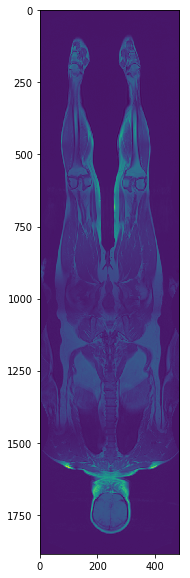

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(rec_numpy)
plt.show()

In [48]:
fake_scan = np.load('./fake_A.npz')['data']

(1886, 162, 485)


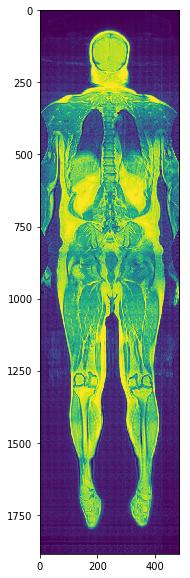

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(fake_scan[100,:,:]))
plt.show()

In [6]:
import SimpleITK as sitk

In [7]:
crop = {
    '10000005_1_CT_wb': [500, 1100, 200, 310, 60, 360],
    '10000006_1_CT_wb': [400, 950, 230, 300, 90, 420],
    '10000135_1_CTce_ThAb': [100, 700, 175, 270, 20, 320],
    '10000136_1_CTce_ThAb': [100, 700, 195, 285, 20, 320],
    '10000001_3_MRT1_wb': [950, 1750, 35, 140, 100, 420],
    '10000003_3_MRT1_wb': [950, 1650, 30, 140, 60, 420],
    '10000365_4_MRT1cefs_Ab': [0,500, 80, 170, 0, 400],
    '10000381_4_MRT1cefs_Ab': [0,500, 180, 270, 0, 400]
}

In [8]:
sitk.GetImageFromArray

<function SimpleITK.SimpleITK.GetImageFromArray>

In [36]:
idx = crop.get('10000006_1_CT_wb')
fake_scan = np.load('./fake_scans/fake_MR_10000006_1_CT_wb.npz')['data'][idx[0]:idx[1], idx[2]:idx[3], idx[4]:idx[5]]

In [37]:
fake_scan.shape

(550, 70, 330)

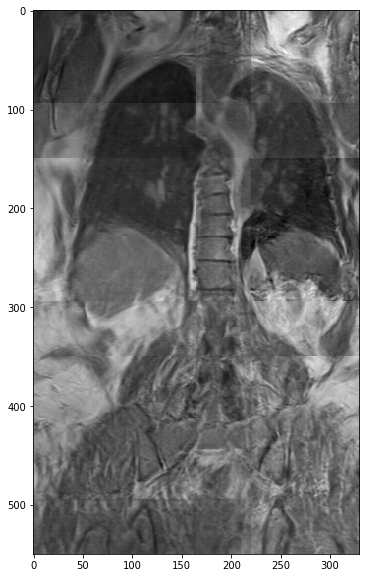

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(fake_scan[:, 40, :]), cmap="gray")
plt.show()

In [39]:
fake_img = sitk.GetImageFromArray(fake_scan)
sitk.WriteImage(fake_img, './fake_scans/fake_MR_10000006_1_CT_wb.nii.gz')